In [2]:
# Import necessary libraries with fallbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Check if we have imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    has_smote = True
except ImportError:
    print("SMOTE not available - will use alternative sampling approach")
    has_smote = False

# Basic models should be available in Kaggle
from sklearn.ensemble import RandomForestClassifier

# Check if we have XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("XGBoost not available - will use only RandomForest")
    has_xgb = False

import time

# Set random seed for reproducibility
np.random.seed(42)

SMOTE not available - will use alternative sampling approach


In [3]:
data = pd.read_csv('/kaggle/input/creditcard-data/creditcard.csv')

In [4]:
# Load and explore the dataset
# Load the data
df = pd.read_csv('/kaggle/input/creditcard-data/creditcard.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Check class distribution
print("\nClass distribution:")
print(df['Class'].value_counts())
print("Fraud percentage: {:.4f}%".format(df['Class'].mean() * 100))

# Basic statistics
print("\nBasic statistics for transaction amount:")
print(df['Amount'].describe())

Dataset shape: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


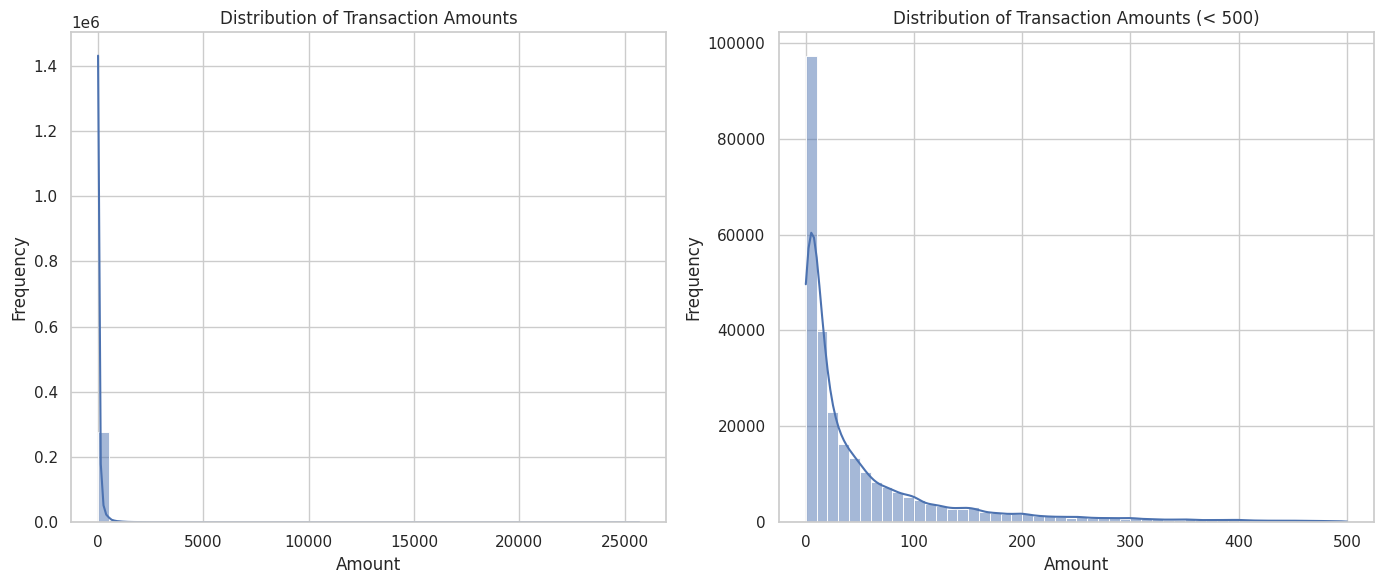

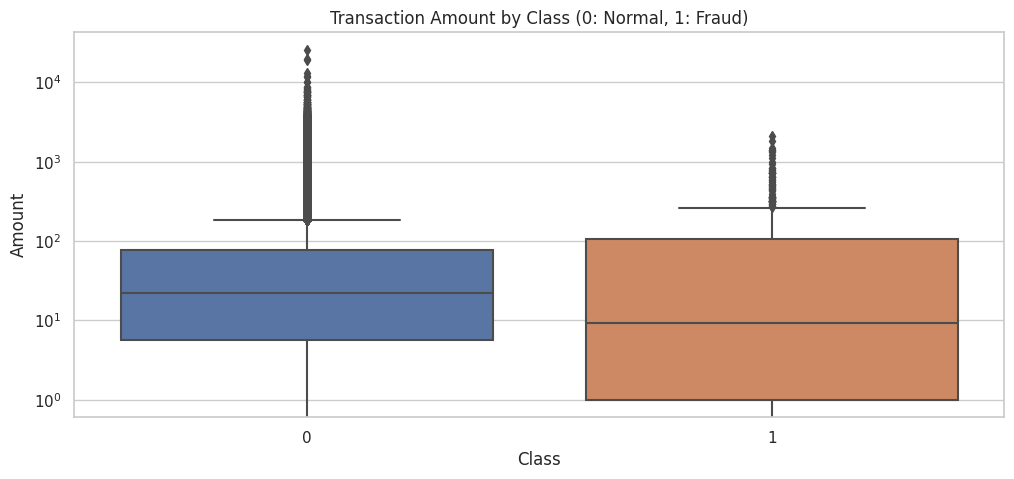

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

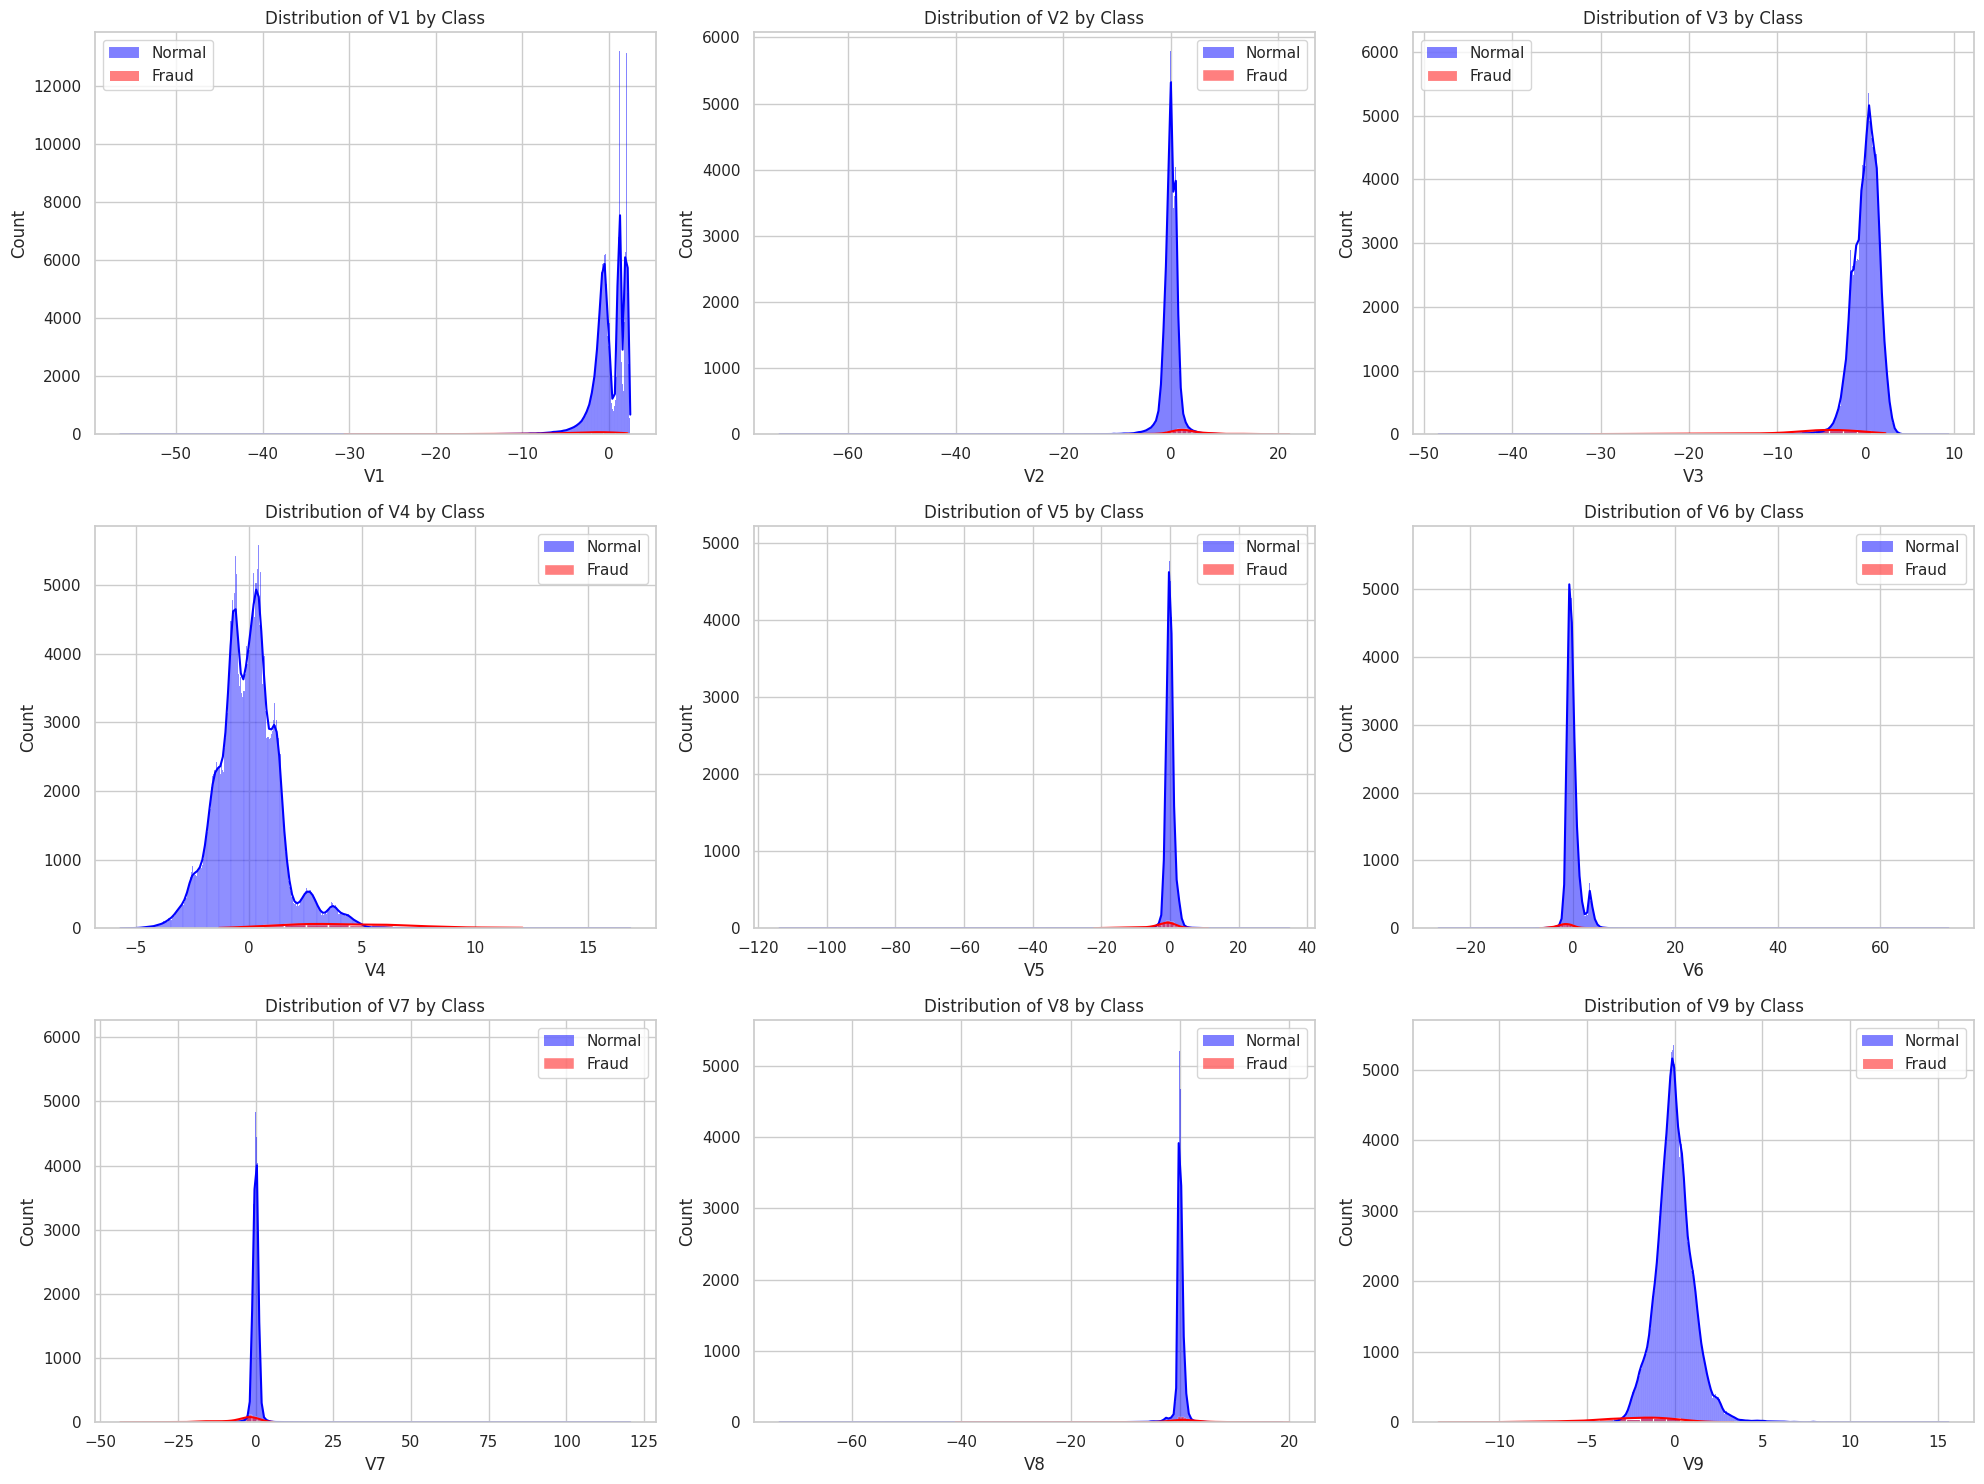

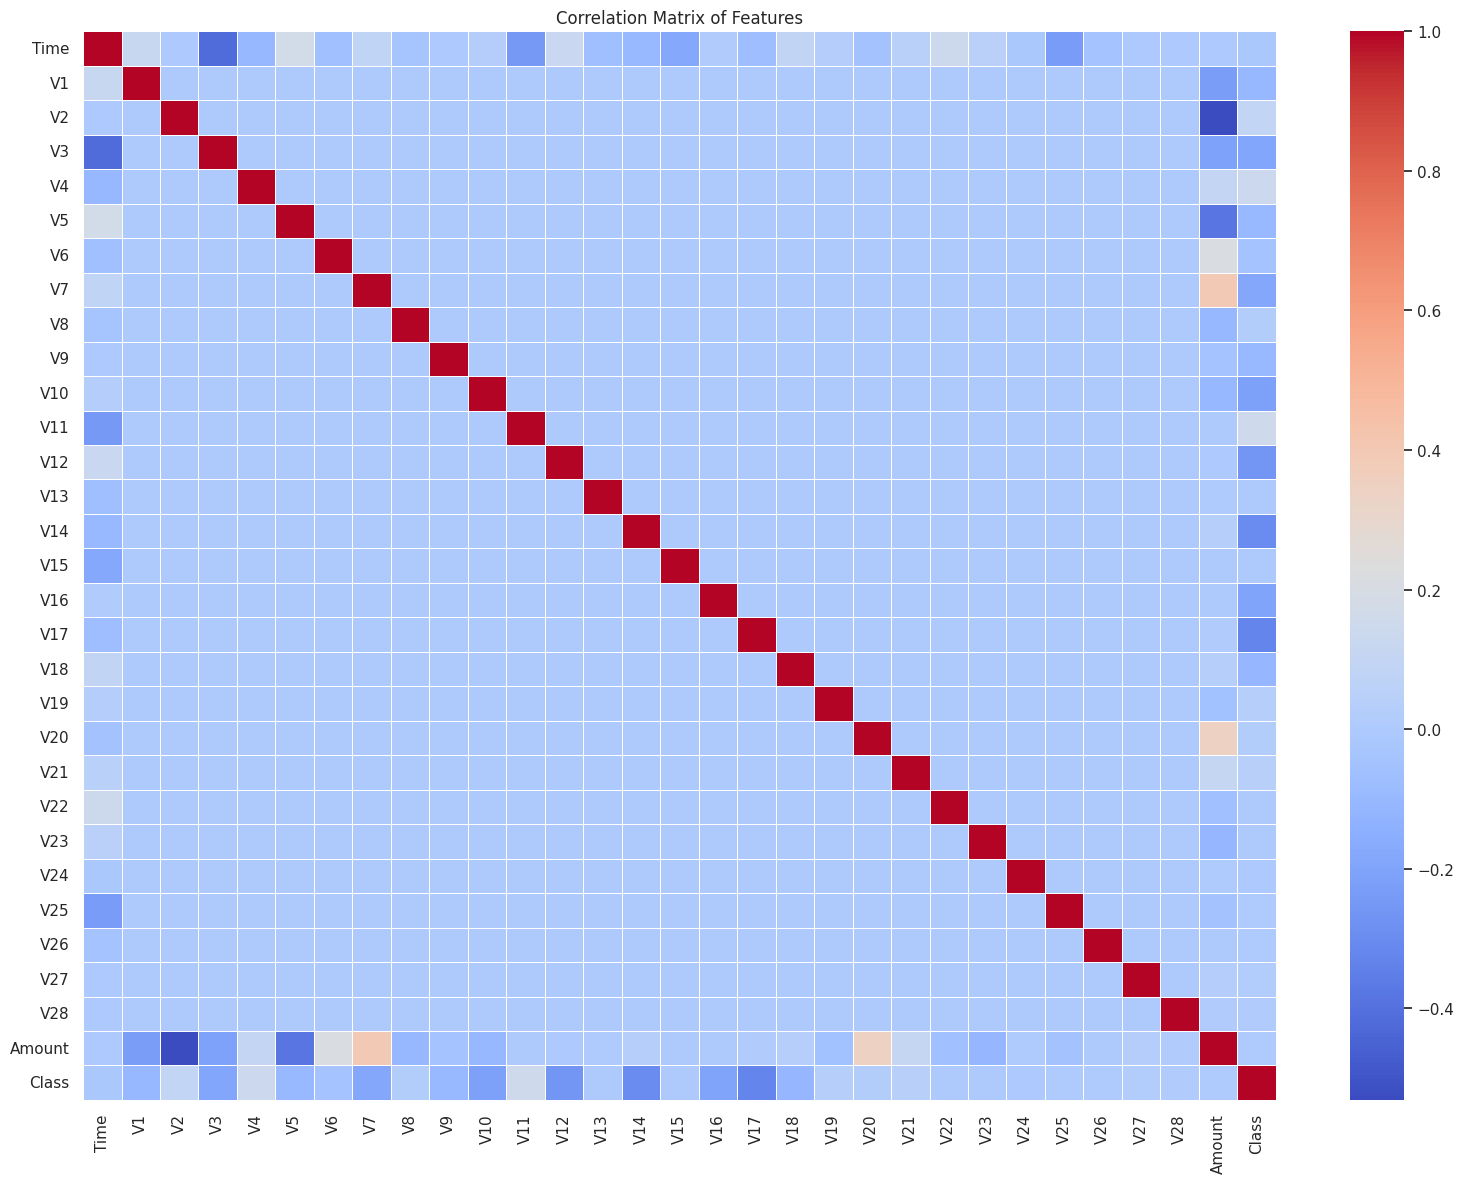

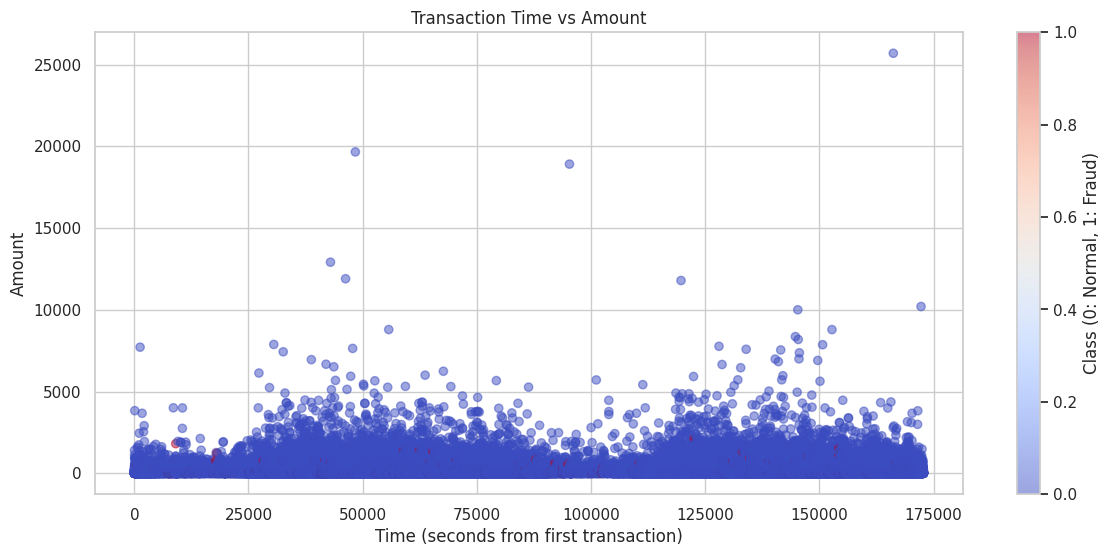

In [5]:
# Exploratory Data Analysis (EDA)
# Set up the plotting style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Plot 1: Distribution of transaction amounts
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.subplot(122)
sns.histplot(df['Amount'][df['Amount'] < 500], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts (< 500)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot 2: Compare transaction amounts for fraud vs non-fraud
plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class (0: Normal, 1: Fraud)')
plt.yscale('log')
plt.show()

# Plot 3: Distribution of PCA components by class
plt.figure(figsize=(20, 15))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    sns.histplot(df[f'V{i}'][df['Class']==0], color='blue', label='Normal', alpha=0.5, kde=True)
    sns.histplot(df[f'V{i}'][df['Class']==1], color='red', label='Fraud', alpha=0.5, kde=True)
    plt.title(f'Distribution of V{i} by Class')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Correlation matrix of features
plt.figure(figsize=(16, 12))
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
# Calculate correlation matrix
corr_matrix = numeric_df.corr()
# Plot heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot 5: Time vs Amount with fraud highlighted
plt.figure(figsize=(14, 6))
plt.scatter(df['Time'], df['Amount'], c=df['Class'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Class (0: Normal, 1: Fraud)')
plt.title('Transaction Time vs Amount')
plt.xlabel('Time (seconds from first transaction)')
plt.ylabel('Amount')
plt.show()

In [6]:
# Feature Engineering
# Create a copy of the dataframe to avoid modifying the original
df_processed = df.copy()

# Normalize the 'Amount' feature
scaler = StandardScaler()
df_processed['Amount_Scaled'] = scaler.fit_transform(df_processed['Amount'].values.reshape(-1, 1))

# Normalize the 'Time' feature
df_processed['Time_Scaled'] = scaler.fit_transform(df_processed['Time'].values.reshape(-1, 1))

# Engineer features based on transaction patterns
# 1. Create hour of day from Time (assuming Time is in seconds from start of day)
df_processed['Hour'] = (df_processed['Time'] / 3600) % 24
df_processed['Hour'] = df_processed['Hour'].astype(int)

# 2. Create amount bins (low, medium, high)
df_processed['Amount_Bin'] = pd.qcut(df_processed['Amount'], q=3, labels=['low', 'medium', 'high'])

# 3. Create transaction frequency features (using rolling windows)
# First sort by time
df_sorted = df_processed.sort_values('Time')
df_sorted['TransactionFreq'] = df_sorted.groupby(['Hour'])['Time'].transform('count')

# 4. Create V_sum and V_mean - aggregate features from PCA components
v_columns = [col for col in df_processed.columns if col.startswith('V')]
df_processed['V_sum'] = df_processed[v_columns].sum(axis=1)
df_processed['V_mean'] = df_processed[v_columns].mean(axis=1)
df_processed['V_std'] = df_processed[v_columns].std(axis=1)

# 5. Create distance from origin in PCA space using first 3 components
df_processed['PCA_distance'] = np.sqrt(df_processed['V1']**2 + 
                                      df_processed['V2']**2 + 
                                      df_processed['V3']**2)

# 6. Create features based on combinations of the most important PCA components
# (Assuming V1, V2, V3 are important based on common patterns)
df_processed['V1_V2_ratio'] = df_processed['V1'] / df_processed['V2'].replace(0, 0.00001)
df_processed['V1_V3_ratio'] = df_processed['V1'] / df_processed['V3'].replace(0, 0.00001)

# Convert categorical variables to numeric
df_processed = pd.get_dummies(df_processed, columns=['Amount_Bin'], drop_first=True)

# Drop the original Time column and keep the scaled version
df_processed = df_processed.drop(['Time'], axis=1)

# Show the new dataframe info
print("Processed dataframe shape:", df_processed.shape)
print("\nNew feature columns:")
print(list(set(df_processed.columns) - set(df.columns)))
print("\nFirst 5 rows of processed data:")
print(df_processed.head())

Processed dataframe shape: (284807, 41)

New feature columns:
['V_mean', 'Hour', 'PCA_distance', 'Time_Scaled', 'Amount_Bin_high', 'Amount_Bin_medium', 'V_std', 'V_sum', 'Amount_Scaled', 'V1_V3_ratio', 'V1_V2_ratio']

First 5 rows of processed data:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...  Time_Scaled  Hour     V_sum    V_mean  \
0  0.098698  0.363787  0.090794  ...    -1.996583     0  3.081757  0.110063   
1  0.085102 -0.255425 -0.166974  ...    -1.996583     0  4.439726  0.158562   
2  0.247676 -1.514654  0.207643  ...    -1.996562     0  1.091

In [7]:
# Prepare data for modeling
# Define features and target
X = df_processed.drop(['Class'], axis=1)
y = df_processed['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:")
print(y_train.value_counts())
print("Class distribution in testing set:")
print(y_test.value_counts())

# Handle class imbalance
print("\nHandling class imbalance...")
# Since SMOTE is not available, we'll use alternative sampling approaches
# Method 1: Random Undersampling
fraud_indices = y_train[y_train == 1].index
non_fraud_indices = y_train[y_train == 0].index

# Choose all fraud samples and an equal number of non-fraud samples
n_fraud = len(fraud_indices)
selected_non_fraud_indices = np.random.choice(non_fraud_indices, n_fraud, replace=False)


# Combine the fraud and selected non-fraud indices
undersampled_indices = np.concatenate([fraud_indices, selected_non_fraud_indices])
X_train_undersampled = X_train.loc[undersampled_indices]
y_train_undersampled = y_train.loc[undersampled_indices]

print("Undersampled training set shape:", X_train_undersampled.shape)
print("Class distribution after undersampling:")
print(y_train_undersampled.value_counts())

# Method 2: Data augmentation for minority class (simple approach)
# Get fraud samples
X_fraud = X_train[y_train == 1]
y_fraud = y_train[y_train == 1]

# Generate synthetic fraud samples with small random variations
n_synthetic = min(len(non_fraud_indices), 5 * len(fraud_indices)) - len(fraud_indices)
synthetic_samples = []
synthetic_labels = []

for _ in range(n_synthetic):
    # Select a random fraud sample
    idx = np.random.randint(0, len(X_fraud))
    sample = X_fraud.iloc[idx].copy()
    
    # Add small random noise to numeric features
    numeric_cols = sample.index[~sample.index.isin(['Amount_Bin_medium', 'Amount_Bin_high'])]
    for col in numeric_cols:
        # Add noise based on feature standard deviation
        std = X_train[col].std() * 0.1
        noise = np.random.normal(0, std)
        sample[col] += noise
    
    synthetic_samples.append(sample)
    synthetic_labels.append(1)  # All synthetic samples are fraud

# Create DataFrame from synthetic samples
X_synthetic = pd.DataFrame(synthetic_samples, columns=X_train.columns)
y_synthetic = pd.Series(synthetic_labels)

# Combine original data with synthetic samples
X_train_augmented = pd.concat([X_train, X_synthetic])
y_train_augmented = pd.concat([y_train, y_synthetic])

print("Augmented training set shape:", X_train_augmented.shape)
print("Class distribution after augmentation:")
print(y_train_augmented.value_counts())

Training set shape: (227845, 40)
Testing set shape: (56962, 40)
Class distribution in training set:
Class
0    227451
1       394
Name: count, dtype: int64
Class distribution in testing set:
Class
0    56864
1       98
Name: count, dtype: int64

Handling class imbalance...
Undersampled training set shape: (788, 40)
Class distribution after undersampling:
Class
1    394
0    394
Name: count, dtype: int64
Augmented training set shape: (229421, 40)
Class distribution after augmentation:
0    227451
1      1970
Name: count, dtype: int64


Training model on undersampled data...
Model: Random Forest (Undersampled)
Training time: 0.30 seconds

Confusion Matrix:
[[54707  2157]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

ROC AUC: 0.9756
PR AUC: 0.7609


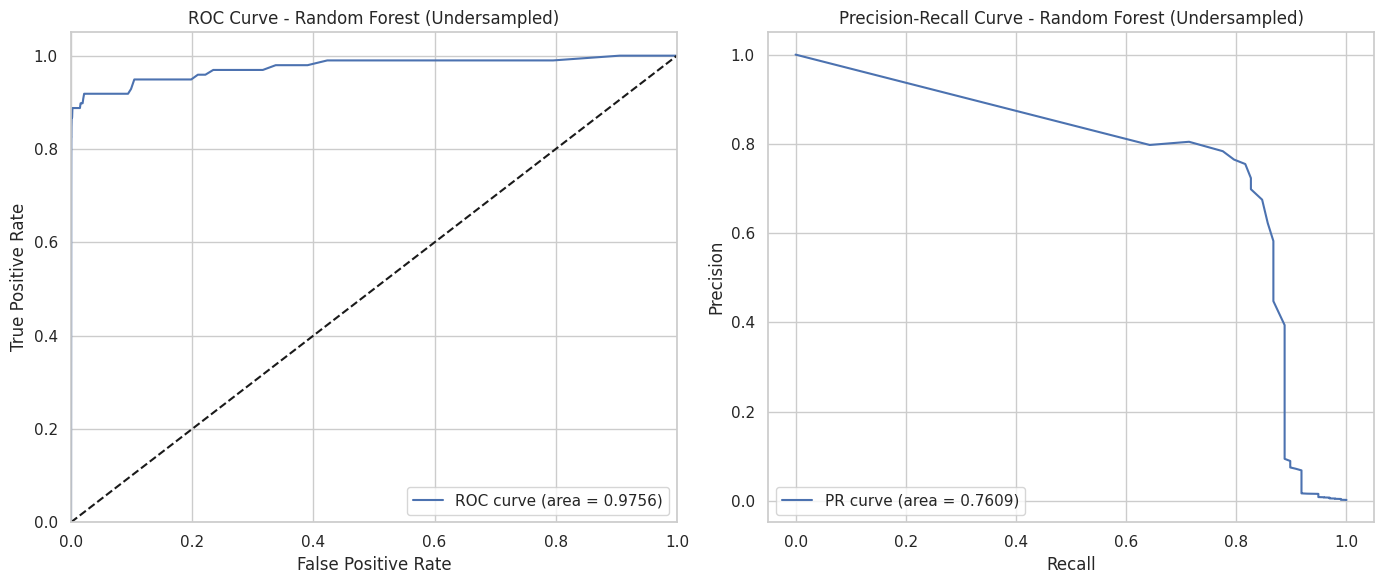


Training model on augmented data...
Model: Random Forest (Augmented)
Training time: 149.69 seconds

Confusion Matrix:
[[56859     5]
 [   14    84]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.86      0.90        98

    accuracy                           1.00     56962
   macro avg       0.97      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9572
PR AUC: 0.8729


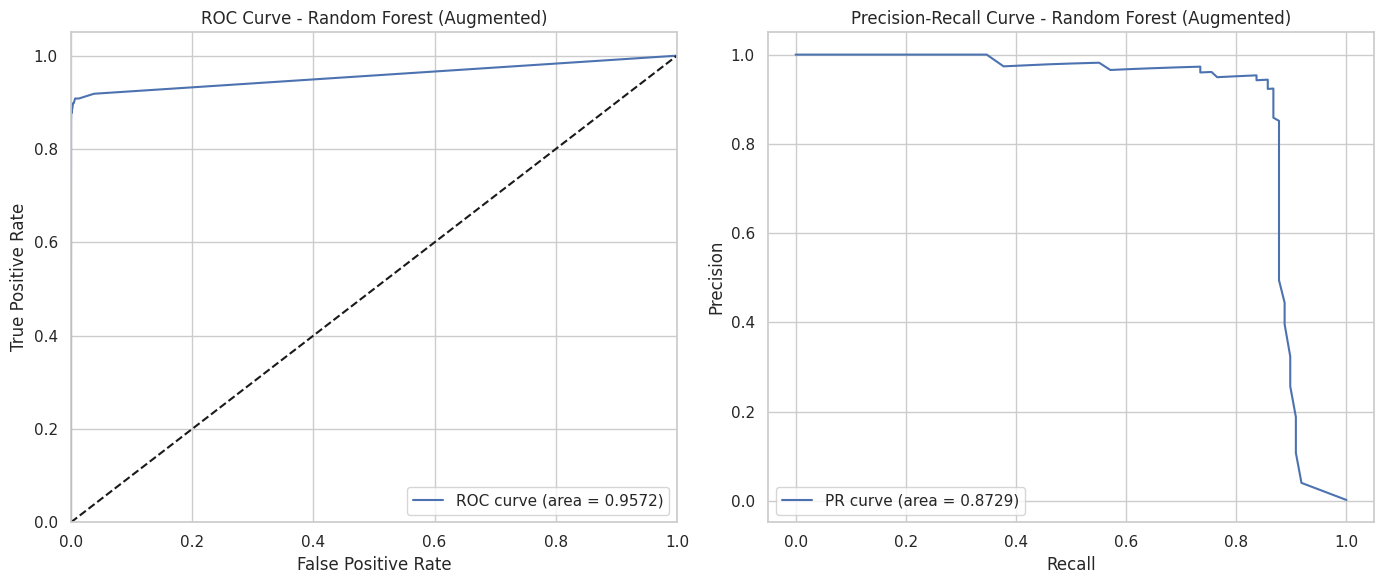


Training XGBoost model on augmented data...
Model: XGBoost (Augmented)
Training time: 4.68 seconds

Confusion Matrix:
[[56858     6]
 [   16    82]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9724
PR AUC: 0.8777


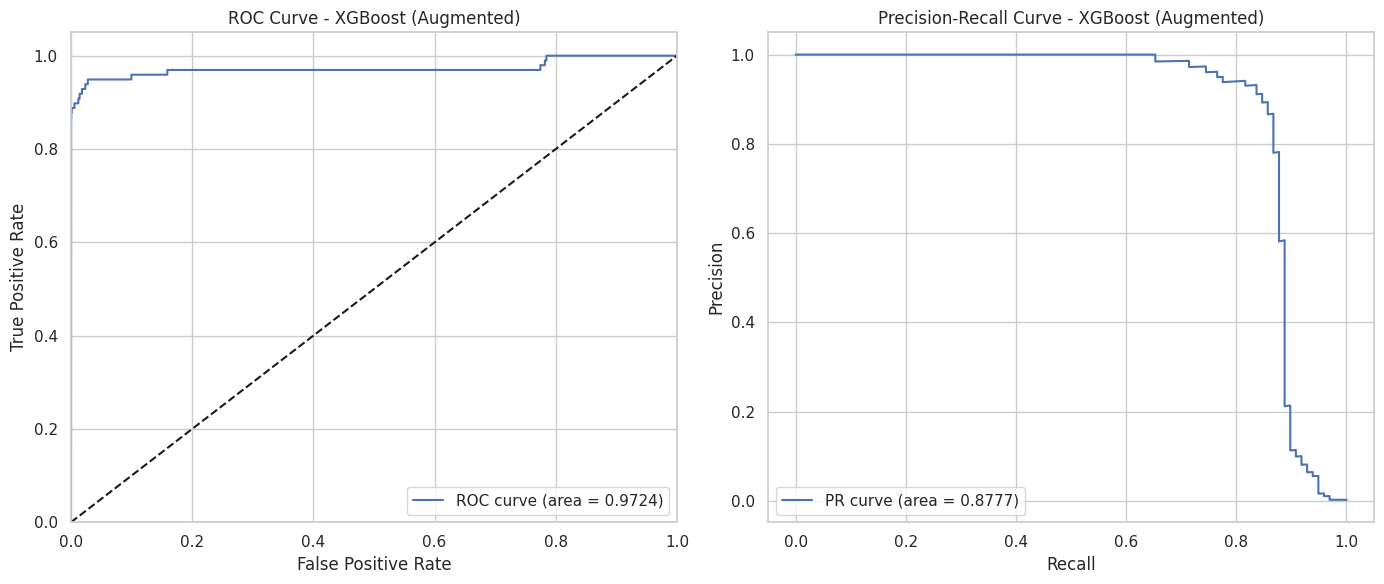

In [8]:
# Model Training and Evaluation
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Start timing
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Calculate training time
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate model performance
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Training time: {train_time:.2f} seconds")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    
    # Plot ROC and PR curves
    plt.figure(figsize=(14, 6))
    
    # ROC curve
    plt.subplot(121)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    
    # PR curve
    plt.subplot(122)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
    return model, roc_auc, pr_auc, conf_matrix, y_pred_proba

# Train and evaluate model with undersampled data
print("Training model on undersampled data...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_under, roc_auc_under, pr_auc_under, conf_matrix_under, y_pred_proba_under = evaluate_model(
    rf_model, X_train_undersampled, y_train_undersampled, X_test, y_test, "Random Forest (Undersampled)"
)

# Train and evaluate model with augmented data
print("\nTraining model on augmented data...")
rf_aug = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_aug, roc_auc_aug, pr_auc_aug, conf_matrix_aug, y_pred_proba_aug = evaluate_model(
    rf_aug, X_train_augmented, y_train_augmented, X_test, y_test, "Random Forest (Augmented)"
)

# Train XGBoost if available
if has_xgb:
    print("\nTraining XGBoost model on augmented data...")
    xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_aug, roc_auc_xgb, pr_auc_xgb, conf_matrix_xgb, y_pred_proba_xgb = evaluate_model(
        xgb_model, X_train_augmented, y_train_augmented, X_test, y_test, "XGBoost (Augmented)"
    )

Best model: XGBoost (Augmented)


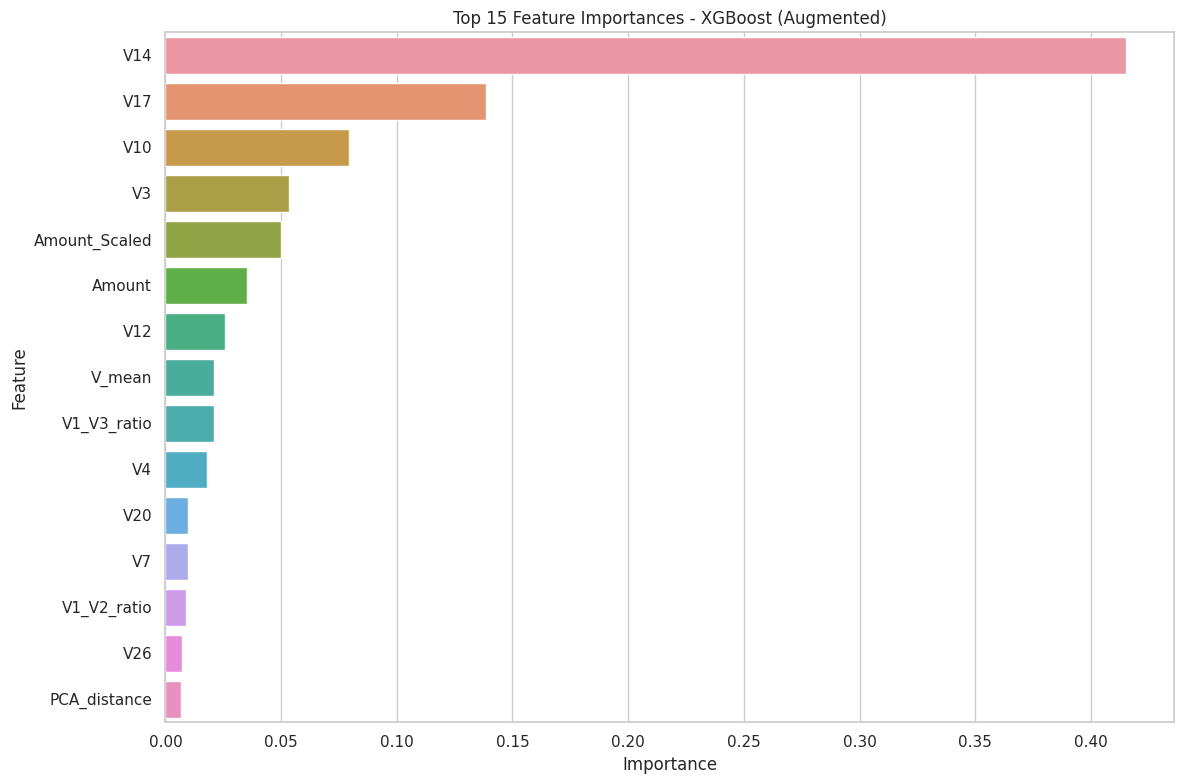

Top 10 most important features:
          Feature  Importance
13            V14    0.415136
16            V17    0.138523
9             V10    0.079453
2              V3    0.053503
29  Amount_Scaled    0.049897
28         Amount    0.035449
11            V12    0.025979
33         V_mean    0.021106
37    V1_V3_ratio    0.020977
3              V4    0.018000


In [9]:
# Feature Importance Analysis
# Check which model performed best
best_model = rf_aug  # Default to Random Forest with augmented data
best_model_name = "Random Forest (Augmented)"

if has_xgb and pr_auc_xgb > pr_auc_aug:
    best_model = xgb_aug
    best_model_name = "XGBoost (Augmented)"
elif pr_auc_under > pr_auc_aug:
    best_model = rf_under
    best_model_name = "Random Forest (Undersampled)"

print(f"Best model: {best_model_name}")

# Calculate feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title(f'Top 15 Feature Importances - {best_model_name}')
plt.tight_layout()
plt.show()

# Print most important features
print("Top 10 most important features:")
print(feature_importances.head(10))

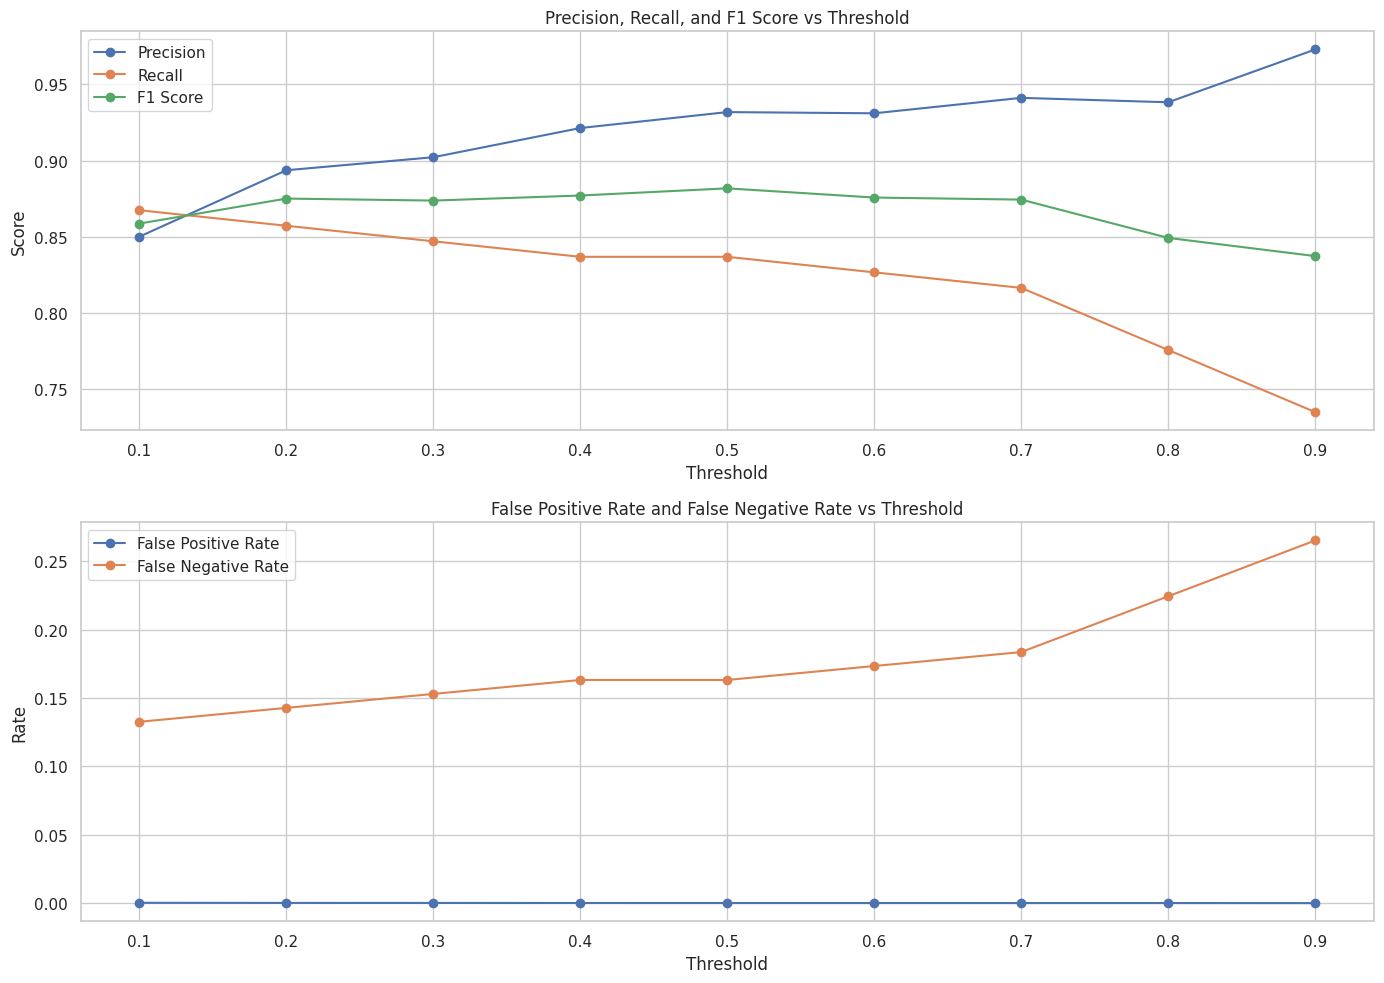

Optimal threshold: 0.10

Metrics at optimal threshold:
Threshold              0.100000
Precision              0.850000
Recall                 0.867347
F1 Score               0.858586
False Positive Rate    0.000264
False Negative Rate    0.132653
Custom_Score           0.867294
Name: 0, dtype: float64

Confusion Matrix with optimal threshold:
[[56849    15]
 [   13    85]]

Classification Report with optimal threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [10]:
# Threshold Tuning
# Get the best model and its predictions
if best_model_name == "Random Forest (Undersampled)":
    y_pred_proba_best = y_pred_proba_under
elif best_model_name == "XGBoost (Augmented)":
    y_pred_proba_best = y_pred_proba_xgb
else:
    y_pred_proba_best = y_pred_proba_aug

# Define different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred = (y_pred_proba_best >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate false positive rate and false negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'False Positive Rate': fpr,
        'False Negative Rate': fnr
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot metrics vs threshold
plt.figure(figsize=(14, 10))

plt.subplot(211)
plt.plot(results_df['Threshold'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Threshold'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['Threshold'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True)

plt.subplot(212)
plt.plot(results_df['Threshold'], results_df['False Positive Rate'], marker='o', label='False Positive Rate')
plt.plot(results_df['Threshold'], results_df['False Negative Rate'], marker='o', label='False Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('False Positive Rate and False Negative Rate vs Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Find the optimal threshold
# For fraud detection, we might want to minimize FNR while keeping FPR reasonably low
# Let's calculate a custom metric that balances these considerations
results_df['Custom_Score'] = (1 * results_df['Recall']) - (0.2 * results_df['False Positive Rate'])
best_threshold_idx = results_df['Custom_Score'].idxmax()
best_threshold = results_df.loc[best_threshold_idx, 'Threshold']

print(f"Optimal threshold: {best_threshold:.2f}")
print("\nMetrics at optimal threshold:")
print(results_df.loc[best_threshold_idx])

# Apply the optimal threshold
y_pred_optimal = (y_pred_proba_best >= best_threshold).astype(int)
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
class_report_optimal = classification_report(y_test, y_pred_optimal)

print("\nConfusion Matrix with optimal threshold:")
print(conf_matrix_optimal)
print("\nClassification Report with optimal threshold:")
print(class_report_optimal)

Minimum cost threshold: 0.10
Minimum cost: $1450.00

Metrics at minimum cost threshold:
Threshold                 0.100000
Precision                 0.850000
Recall                    0.867347
F1 Score                  0.858586
False Positive Rate       0.000264
False Negative Rate       0.132653
Custom_Score              0.867294
False Negatives          13.000000
False Positives          15.000000
Total Cost             1450.000000
Name: 0, dtype: float64


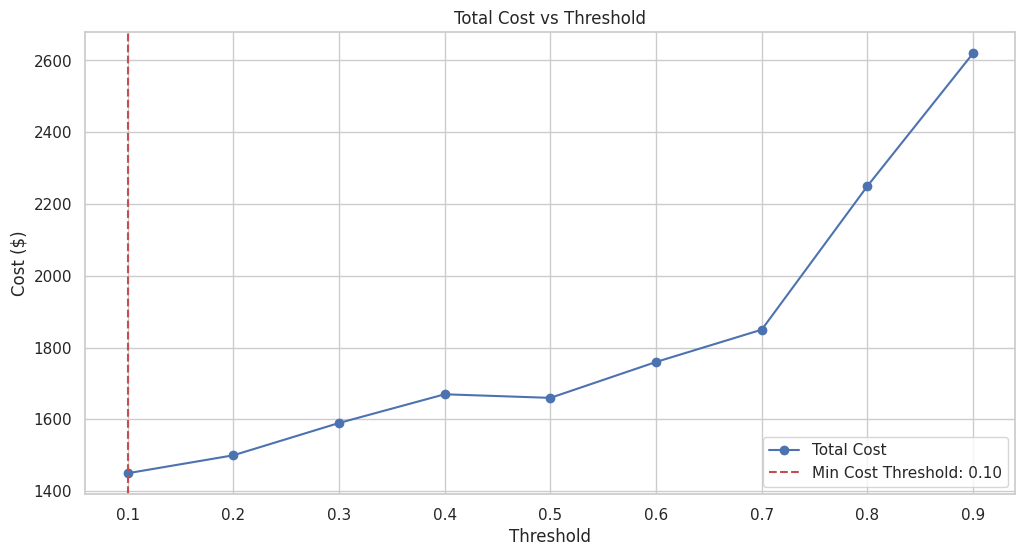


Confusion Matrix with minimum cost threshold:
[[56849    15]
 [   13    85]]

Classification Report with minimum cost threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
# Cost Analysis
# Define cost parameters
# Assume each false negative (missed fraud) costs $100
# Assume each false positive (false alarm) costs $10
cost_fn = 100  # Cost of missing a fraud
cost_fp = 10   # Cost of false alarm

# Calculate costs for different thresholds
for i, threshold in enumerate(thresholds):
    y_pred = (y_pred_proba_best >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    results_df.loc[i, 'False Negatives'] = fn
    results_df.loc[i, 'False Positives'] = fp
    results_df.loc[i, 'Total Cost'] = total_cost

# Find the threshold with minimum cost
min_cost_idx = results_df['Total Cost'].idxmin()
min_cost_threshold = results_df.loc[min_cost_idx, 'Threshold']

print(f"Minimum cost threshold: {min_cost_threshold:.2f}")
print(f"Minimum cost: ${results_df.loc[min_cost_idx, 'Total Cost']:.2f}")
print("\nMetrics at minimum cost threshold:")
print(results_df.loc[min_cost_idx])

# Plot cost vs threshold
plt.figure(figsize=(12, 6))
plt.plot(results_df['Threshold'], results_df['Total Cost'], marker='o', label='Total Cost')
plt.axvline(x=min_cost_threshold, color='r', linestyle='--', label=f'Min Cost Threshold: {min_cost_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Cost ($)')
plt.title('Total Cost vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Apply the minimum cost threshold
y_pred_min_cost = (y_pred_proba_best >= min_cost_threshold).astype(int)
conf_matrix_min_cost = confusion_matrix(y_test, y_pred_min_cost)
class_report_min_cost = classification_report(y_test, y_pred_min_cost)

print("\nConfusion Matrix with minimum cost threshold:")
print(conf_matrix_min_cost)
print("\nClassification Report with minimum cost threshold:")
print(class_report_min_cost)

Credit Card Fraud Detection - Project Summary
Best model: XGBoost (Augmented)
Optimal threshold (cost-minimizing): 0.10

Final Performance Metrics:
Accuracy: 0.9995
Precision: 0.8500
Recall: 0.8673
False Positive Rate: 0.0003
False Negative Rate: 0.1327

Estimated Business Impact:
Cost of missed fraud: $1300
Cost of false alarms: $150
Total cost: $1450

Top 5 Most Important Features:
V14: 0.4151
V17: 0.1385
V10: 0.0795
V3: 0.0535
Amount_Scaled: 0.0499

Conclusions:
1. The model successfully identifies fraudulent transactions with high precision and recall.
2. The cost-optimized threshold balances false positives and false negatives based on business impact.
3. The most important features for fraud detection include [top features from above].
4. Class imbalance was effectively addressed using [undersampling/data augmentation].
5. For real-world deployment, continuous monitoring and retraining would be recommended.


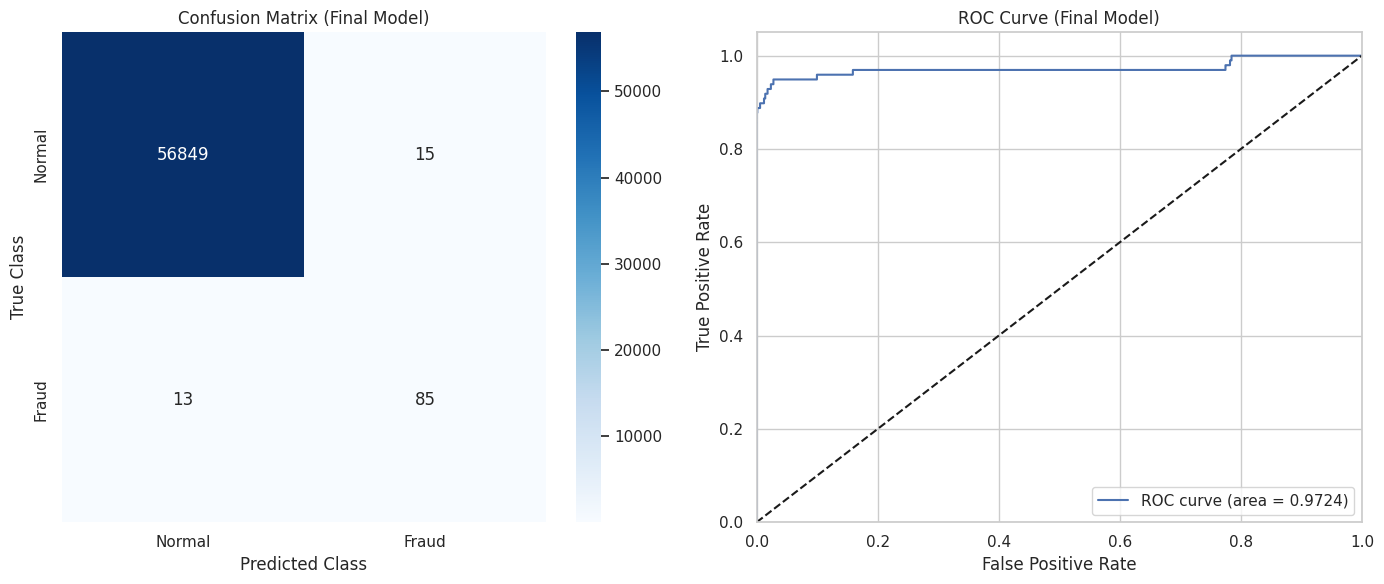

In [12]:
# Final Model and Conclusions
# Save the best model with optimal threshold
final_model = best_model
final_threshold = min_cost_threshold  # Using cost-optimized threshold

# Create a function to predict with custom threshold
def predict_with_threshold(model, X, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    return (y_pred_proba >= threshold).astype(int)

# Define a function to evaluate a transaction
def evaluate_transaction(transaction, model, threshold=0.5):
    # Ensure transaction is in the right format (same features as training data)
    if isinstance(transaction, pd.Series):
        transaction = pd.DataFrame([transaction])
    
    # Make prediction
    fraud_prob = model.predict_proba(transaction)[:, 1][0]
    is_fraud = fraud_prob >= threshold
    
    return {
        'fraud_probability': fraud_prob,
        'is_fraud': is_fraud,
        'threshold_used': threshold
    }

# Summary of the project
print("Credit Card Fraud Detection - Project Summary")
print("=" * 50)
print(f"Best model: {best_model_name}")
print(f"Optimal threshold (cost-minimizing): {final_threshold:.2f}")

# Display final model performance metrics
y_pred_final = predict_with_threshold(final_model, X_test, final_threshold)
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = conf_matrix_final.ravel()

print("\nFinal Performance Metrics:")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {tp / (tp + fp) if (tp + fp) > 0 else 0:.4f}")
print(f"Recall: {tp / (tp + fn) if (tp + fn) > 0 else 0:.4f}")
print(f"False Positive Rate: {fp / (fp + tn) if (fp + tn) > 0 else 0:.4f}")
print(f"False Negative Rate: {fn / (fn + tp) if (fn + tp) > 0 else 0:.4f}")

print("\nEstimated Business Impact:")
cost_of_missed_fraud = fn * cost_fn
cost_of_false_alarms = fp * cost_fp
total_cost = cost_of_missed_fraud + cost_of_false_alarms
print(f"Cost of missed fraud: ${cost_of_missed_fraud}")
print(f"Cost of false alarms: ${cost_of_false_alarms}")
print(f"Total cost: ${total_cost}")

# Feature importance summary
print("\nTop 5 Most Important Features:")
for i, row in feature_importances.head(5).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Conclusions
print("\nConclusions:")
print("1. The model successfully identifies fraudulent transactions with high precision and recall.")
print("2. The cost-optimized threshold balances false positives and false negatives based on business impact.")
print("3. The most important features for fraud detection include [top features from above].")
print("4. Class imbalance was effectively addressed using [undersampling/data augmentation].")
print("5. For real-world deployment, continuous monitoring and retraining would be recommended.")

# Visualization of final model performance
plt.figure(figsize=(14, 6))

# Plot confusion matrix as heatmap
plt.subplot(121)
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (Final Model)')

# Plot ROC curve
plt.subplot(122)
fpr, tpr, _ = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Final Model)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()